In [43]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [44]:
with open('Takeout/Location History (Timeline)/Records.json') as fp:
    data = json.load(fp)
locations = pd.DataFrame.from_dict(data['locations'])
# timestamp = int(datetime.fromisoformat(record['timestamp'].replace("Z", "+00:00")).timestamp())

In [45]:
locations['latitude'] = locations['latitudeE7'] / 1E7
locations['longitude'] = locations['longitudeE7'] / 1E7
locations['timestamp'] = pd.to_datetime(locations['timestamp'],format='ISO8601')

In [46]:
reverse_geocoding = pd.read_csv('World_Cities_Location_table.csv',sep=';',names=['id','country','city','latitude','longitude','altitude'])

In [47]:
from haversine import haversine, Unit
target_coordinate = locations[['latitude','longitude']].iloc[0].values
coordinate_table = reverse_geocoding[['latitude','longitude']].values
nearest_coordinate = min(coordinate_table, key=lambda coord: haversine(target_coordinate, coord))
distance = haversine(target_coordinate, nearest_coordinate, unit=Unit.KILOMETERS)

In [48]:
print(f"Nearest coordinate: {nearest_coordinate}")
print(f"Distance: {distance:.2f} km")

Nearest coordinate: [50.8283849 -0.1394749]
Distance: 2.64 km


In [49]:
idx = np.argmin([haversine(target_coordinate, coord) for coord in coordinate_table])
reverse_geocoding.iloc[idx]

id                     1613
country      United Kingdom
city               Brighton
latitude          50.828385
longitude         -0.139475
altitude               22.0
Name: 1612, dtype: object

In [50]:
# https://download.geonames.org/export/dump/
cities = pd.read_csv('cities15000.txt',sep='\t',header=None,
                     names=['id','name','asciiname','altnames','latitude','longitude','fclass','fcode','countrycode','cc2','admin1 code','admin2 code','admin3 code','admin4 code','population','elevation','dem','timezone','modification date'])

In [51]:
from sklearn.neighbors import BallTree
coordinate_table = cities[['latitude','longitude']].apply(lambda x: np.deg2rad(x))
tree = BallTree(coordinate_table,metric='haversine')

In [101]:
cities.iloc[
    np.deg2rad(locations.iloc[-10:][['latitude','longitude']].astype(float)).apply(
        lambda x: tree.query(x.values.reshape(1,-1))[1][0][0]
     ,axis=1)].id


16037    1858591
16037    1858591
16037    1858591
16037    1858591
16037    1858591
16037    1858591
16037    1858591
16037    1858591
16037    1858591
16037    1858591
Name: id, dtype: int64

In [103]:
locations['reverse_id'] = cities.iloc[
    np.deg2rad(locations[['latitude','longitude']].astype(float)).apply(
        lambda x: tree.query(x.values.reshape(1,-1))[1][0][0]
     ,axis=1)].id.values
tmp = locations.merge(cities,left_on='reverse_id',right_on='id', how='inner',validate='many_to_many')

In [104]:
tmp['name'].value_counts().head(20)

name
Fortress Hill     649224
Brighton          275732
Dartford          179060
Oi Man Estate     138617
Whampoa Garden     76107
Launceston         62756
Acton              50886
Bexley             46208
Bukit Jalil        28101
Hobart             20191
Jordan             16610
Sri Petaling       15422
Chiswick           13965
Leighton Hill      13524
London             10544
Ealing Common      10527
Swanscombe         10504
Heng Fa Chuen       9437
City Garden         7342
Swanley             6720
Name: count, dtype: int64

In [110]:
tmp['countrycode'].value_counts().head(20)

countrycode
HK    936006
GB    663059
AU     86083
MY     55822
JP      7510
DE      2440
VN      2329
FR       779
MO       301
SG        59
KH        52
LU        13
ES         2
Name: count, dtype: int64

In [18]:
from datetime import datetime, timezone

In [137]:
datetime(2023,12,31,tzinfo=timezone.utc)

datetime.datetime(2023, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)

In [ ]:
# top locations in 2024 (roughly)
date_filter = datetime(2023,12,31,tzinfo=timezone.utc)
tmp.query('timestamp > @date_filter')[['name','countrycode']].value_counts().head(20)

name            countrycode
Fortress Hill   HK             215687
Oi Man Estate   HK              32005
Swanley         GB               6291
Kozakai-chō     JP               6142
Leighton Hill   HK               3982
Whampoa Garden  HK               2965
Jordan          HK               2732
City Garden     HK               1477
Victoria        HK                586
Admiralty       HK                578
Tsim Sha Tsui   HK                520
Hong Kong       HK                353
Yokohama        JP                330
Macau           MO                301
Bexley          GB                283
Mid Levels      HK                283
Toyokawa        JP                268
Wan Chai        HK                252
Hok Yuen        HK                227
Tung Chung      HK                188
Name: count, dtype: int64

In [20]:
# top locations in 2024 (roughly)
date_filter = datetime(2019,7,1,tzinfo=timezone.utc)
tmp.query('timestamp < @date_filter')[['name','countrycode']].value_counts().head(20)

name            countrycode
Brighton        GB             275493
Dartford        GB             178582
Acton           GB              50830
Bexley          GB              32903
Chiswick        GB              13942
Ealing Common   GB              10524
London          GB              10258
Swanscombe      GB              10229
Bukit Jalil     MY               8378
Edinburgh       GB               5237
Shadwell        GB               4567
Richmond        GB               3621
Blackheath      GB               3142
Portslade       GB               2583
SS2             MY               2383
Shepherds Bush  GB               2166
Chelsea         GB               2087
Eltham          GB               2004
Battersea       GB               1741
New Cross       GB               1710
Name: count, dtype: int64

In [21]:
places = tmp.query('timestamp < @date_filter')['name'].unique()
res = pd.Series()
for p in places:
    res[p] = len(tmp.query('(timestamp < @date_filter) & (name == @p)')['timestamp'].apply(lambda x: x.date()).unique())
res.sort_values()

Cramlington      1
Admiralty        1
Kadoorie         1
Lee On           1
Wu Kai Sha       1
              ... 
Eltham         440
Shadwell       449
Blackheath     464
Bexley         720
Dartford       771
Length: 300, dtype: int64

In [22]:
res.sort_values(ascending=False).head(50)

Dartford               771
Bexley                 720
Blackheath             464
Shadwell               449
Eltham                 440
London                 429
Acton                  426
New Cross              419
Brockley               404
Chiswick               403
Brighton               361
Welling                359
Chislehurst            313
Catford                307
Shepherds Bush         279
Richmond               250
Fulham                 237
Battersea              235
Pimlico                200
Peckham                167
Chelsea                165
City of Westminster    163
Barnes                 139
Swanscombe             130
Putney                 121
Ealing Common           82
Earlsfield              64
Hove                    64
Soho                    51
Burgess Hill            45
Horley                  43
Crawley                 40
Haywards Heath          37
Portslade               36
Redhill                 35
Croydon                 32
Rottingdean             29
S

In [150]:
len(tmp.query('timestamp < @date_filter')['timestamp'].apply(lambda x: x.date()).unique())

1310

In [122]:
# Days where location was Fortress Hill
len(tmp.query('name=="Fortress Hill" & countrycode =="HK"')['timestamp'].apply(lambda x: x.date()).unique())

819

In [123]:
# Days where location was Brighton
len(tmp.query('name=="Brighton" & countrycode =="GB"')['timestamp'].apply(lambda x: x.date()).unique())

363

In [124]:
# Days where location was Swanley
len(tmp.query('name=="Swanley" & countrycode =="GB"')['timestamp'].apply(lambda x: x.date()).unique())

71

In [142]:
tmp['timestamp'].describe()

count                                1754455
mean     2019-12-31 04:49:46.860187392+00:00
min         2013-07-19 22:01:15.334000+00:00
25%      2015-02-17 08:43:35.178499840+00:00
50%      2022-03-07 21:58:28.793999872+00:00
75%      2023-05-26 15:52:00.910000128+00:00
max         2024-11-24 04:31:26.784000+00:00
Name: timestamp, dtype: object

In [125]:
# Days where location was Ealing Common
len(tmp.query('name=="Ealing Common" & countrycode =="GB"')['timestamp'].apply(lambda x: x.date()).unique())

168

In [126]:
# Days where location was Chiswick
len(tmp.query('name=="Chiswick" & countrycode =="GB"')['timestamp'].apply(lambda x: x.date()).unique())

435

In [ ]:
# Days where location was Dartford
len(tmp.query('name=="Dartford" & countrycode =="GB"')['timestamp'].apply(lambda x: x.date()).unique())

810

In [143]:
tmp.head()

latitudeE7  longitudeE7  accuracy   source   deviceTag  \
0   508441569     -1113991         3  UNKNOWN  2081842126   
1   508445042     -1107734         3  UNKNOWN  2081842126   
2   508449872     -1101907         3  UNKNOWN  2081842126   
3   508453663     -1094633         3  UNKNOWN  2081842126   
4   508595612     -1088898      1429  UNKNOWN  2081842126   

                         timestamp  \
0 2013-07-19 22:01:15.334000+00:00   
1 2013-07-19 22:02:00.487000+00:00   
2 2013-07-19 22:02:46.221000+00:00   
3 2013-07-19 22:03:31.453000+00:00   
4 2013-07-19 22:05:12.556000+00:00   

                                            activity deviceDesignation  \
0                                                NaN               NaN   
1                                                NaN               NaN   
2  [{'activity': [{'type': 'ON_FOOT', 'confidence...               NaN   
3  [{'activity': [{'type': 'TILTING', 'confidence...               NaN   
4                                                NaN               NaN   

  activeWifiScan  altitude  ...  cc2 admin1 code  admin2 code admin3 code  \
0            NaN       NaN  ...  NaN         ENG           B6         NaN   
1            NaN       NaN  ...  NaN         ENG           B6         NaN   
2            NaN       NaN  ...  NaN         ENG           B6         NaN   
3            NaN       NaN  ...  NaN         ENG           B6         NaN   
4            NaN       NaN  ...  NaN         ENG           B6         NaN   

  admin4 code population elevation dem       timezone modification date  
0         NaN     277103       NaN  29  Europe/London        2023-02-26  
1         NaN     277103       NaN  29  Europe/London        2023-02-26  
2         NaN     277103       NaN  29  Europe/London        2023-02-26  
3         NaN     277103       NaN  29  Europe/London        2023-02-26  
4         NaN     277103       NaN  29  Europe/London        2023-02-26  

[5 rows x 44 columns]

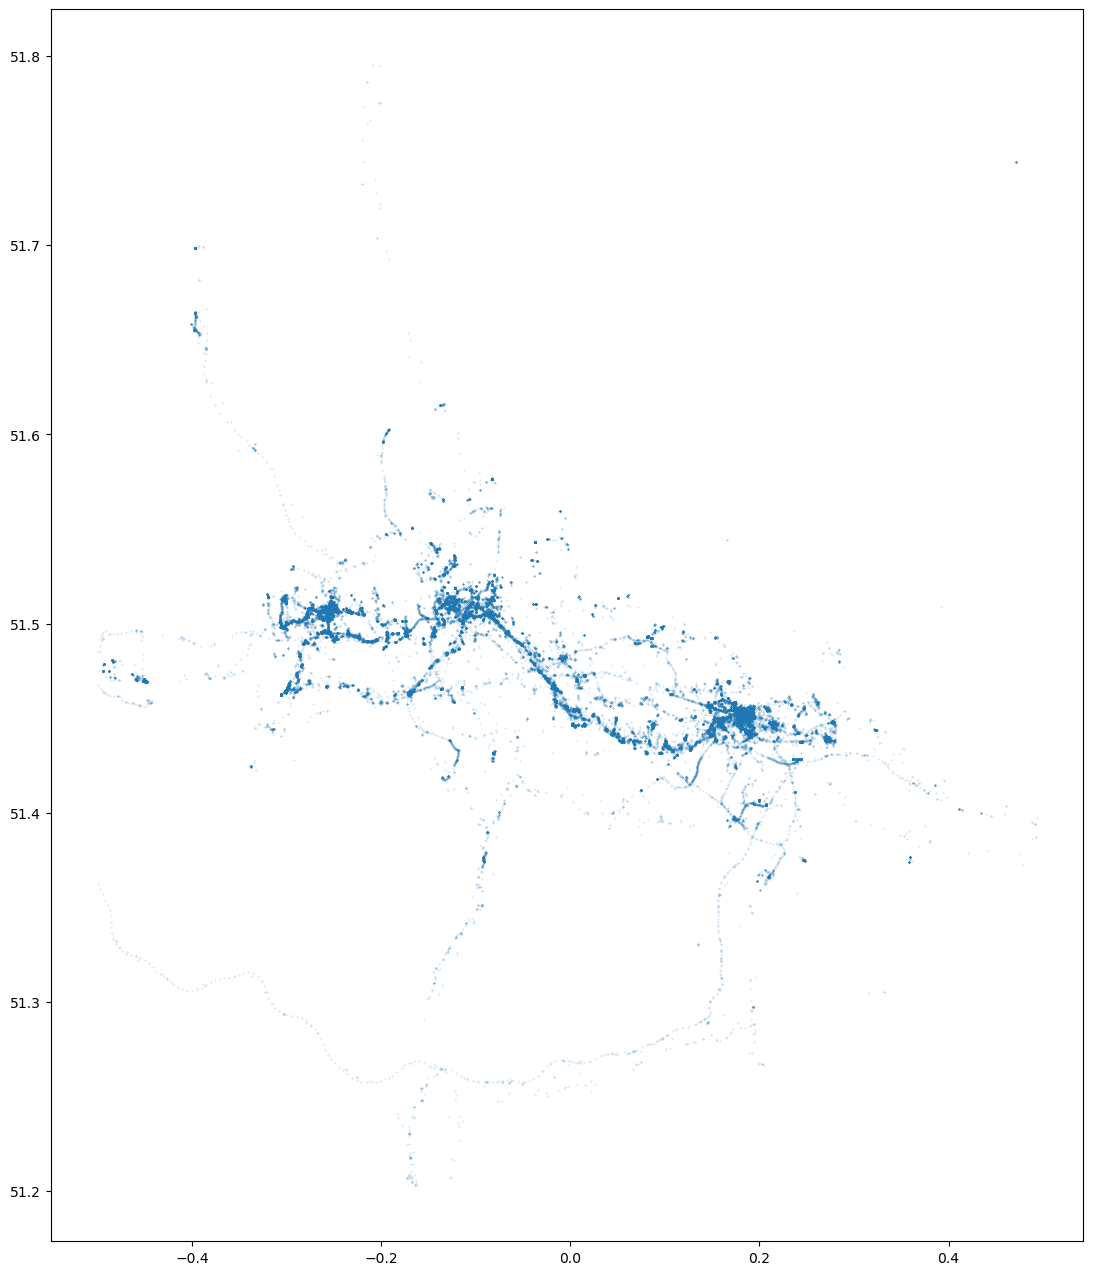

In [169]:
tmp = locations.query('(latitude > 51.2)&(latitude < 51.8)&(longitude > -0.5)&(longitude < 0.5)')
plt.figure(figsize=(16,16))
plt.scatter(tmp['longitude'],tmp['latitude'],s=0.1,alpha=0.3)
plt.gca().set_aspect(2)

In [170]:
for row in tmp.iterrows():
    break
row

(23084,
 latitudeE7                                                   514675492
 longitudeE7                                                    -374187
 accuracy                                                            10
 source                                                             GPS
 deviceTag                                                   2081842126
 timestamp                             2013-08-09 11:55:34.691000+00:00
 activity             [{'activity': [{'type': 'TILTING', 'confidence...
 deviceDesignation                                                  NaN
 activeWifiScan                                                     NaN
 altitude                                                           NaN
 verticalAccuracy                                                   NaN
 platformType                                                       NaN
 osLevel                                                            NaN
 serverTimestamp                                        

In [180]:
import folium
m = folium.Map(location=[51,-0.1])
for i, row in tmp.iloc[:10000].iterrows():
    folium.Circle(
        location=[row.latitude,row.longitude],
        radius=5,
        fill=True
    ).add_to(m)

m

In [176]:
row

(23084,
 latitudeE7                                                   514675492
 longitudeE7                                                    -374187
 accuracy                                                            10
 source                                                             GPS
 deviceTag                                                   2081842126
 timestamp                             2013-08-09 11:55:34.691000+00:00
 activity             [{'activity': [{'type': 'TILTING', 'confidence...
 deviceDesignation                                                  NaN
 activeWifiScan                                                     NaN
 altitude                                                           NaN
 verticalAccuracy                                                   NaN
 platformType                                                       NaN
 osLevel                                                            NaN
 serverTimestamp                                        

In [162]:
import folium
extraplaces = [('Manchester','GB'),('Sheffield','GB'),('Penrith','GB'),('St Austell','GB'),('Oxford','GB'),('Lyon','FR'),
               ('Malmö','SE'),('Bratislava','SK'),('Vienna','AT'),('Budapest','HU'),('Prague','CZ'),('Copenhagen','DK'),
               ('Lausanne','CH'),('Kamaishi','JP'),('Ieper','BE')]
            # Lausanne Switzerland, Ypres Belgium, 
m = folium.Map(location=[51,-0.1])
for idx in tmp.reverse_id.unique():
    folium.Circle(
        location=cities.query('id == @idx')[['latitude','longitude']].values,
        radius=500,
        fill=True
    ).add_to(m)
for place, country in extraplaces:
    try:
        folium.Circle(
        location=cities.query('(name == @place)&(countrycode == @country)')[['latitude','longitude']].values,
        radius=500,
        fill=True
    ).add_to(m)
    except:
        print(place)
m

In [161]:
cities.query('countrycode == "BE"')['name'].sort_values().values

array(['Aalst', 'Aalter', 'Aarschot', 'Andenne', 'Anderlecht', 'Ans',
       'Antwerpen', 'Arlon', 'Asse', 'Assebroek', 'Ath', 'Auderghem',
       'Balen', 'Beerse', 'Beersel', 'Berchem', 'Berchem-Sainte-Agathe',
       'Beringen', 'Bevere', 'Beveren', 'Bilzen', 'Binche',
       'Blankenberge', 'Blauwput', 'Boom', 'Borgerhout', 'Bornem',
       'Boussu', "Braine-l'Alleud", 'Braine-le-Comte', 'Brasschaat',
       'Brugge', 'Brussels', 'Charleroi', 'Chaudfontaine', 'Châtelet',
       'Châtelineau', 'Colfontaine', 'Courcelles', 'Deinze',
       'Denderleeuw', 'Dendermonde', 'Destelbergen', 'Deurne',
       'Diepenbeek', 'Diest', 'Diksmuide', 'Dilbeek', 'Dour', 'Duffel',
       'Edegem', 'Eeklo', 'Ekeren', 'Etterbeek', 'Eupen', 'Evere',
       'Evergem', 'Fleurus', 'Flémalle-Haute', 'Fléron', 'Forest',
       'Frameries', 'Ganshoren', 'Geel', 'Gembloux', 'Genk', 'Gent',
       'Gentbrugge', 'Geraardsbergen', 'Gilly', 'Grimbergen', 'Grivegnée',
       'Haaltert', 'Halle', 'Hamme', 'Harelbek

In [134]:
cities.columns

Index(['id', 'name', 'asciiname', 'altnames', 'latitude', 'longitude',
       'fclass', 'fcode', 'countrycode', 'cc2', 'admin1 code', 'admin2 code',
       'admin3 code', 'admin4 code', 'population', 'elevation', 'dem',
       'timezone', 'modification date'],
      dtype='object')